In [1]:
from efficientnet_pytorch import EfficientNet
from torchinfo import summary            # pip install torchinfo

model = EfficientNet.from_pretrained('efficientnet-b0')
model.eval()

# 1) One‑line, very shallow summary (only top‑level blocks)
summary(model,
        input_size=(1, 3, 224, 224),     # batch, C, H, W
        depth=1,                         # show only first nesting level
        col_names=("num_params",))       # only show parameter counts

# 2) Or: just the total number of parameters
total = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total:,}")


Loaded pretrained weights for efficientnet-b0
Total parameters: 5,288,548


Loaded pretrained weights for efficientnet-b0
File: 000000000033.jpg | GT: big cat | Raw: cheetah | Mapped: big cat | Score: 0.5608
File: 000000000070.jpg | GT: big cat | Raw: cheetah | Mapped: big cat | Score: 0.4706
File: 000000000094.jpg | GT: big cat | Raw: leopard | Mapped: big cat | Score: 0.5755
File: 000000000095.jpg | GT: big cat | Raw: leopard | Mapped: big cat | Score: 0.5225
File: 000000000105.jpg | GT: big cat | Raw: leopard | Mapped: big cat | Score: 0.6648
File: 000000000114.jpg | GT: big cat | Raw: leopard | Mapped: big cat | Score: 0.8371
File: 000000000116.jpg | GT: big cat | Raw: leopard | Mapped: big cat | Score: 0.8211
File: 000000000118.jpg | GT: big cat | Raw: leopard | Mapped: big cat | Score: 0.7218
File: 000000000122.jpg | GT: big cat | Raw: leopard | Mapped: big cat | Score: 0.7657
File: 000000000134.jpg | GT: big cat | Raw: cheetah | Mapped: big cat | Score: 0.6555
File: 000000000146.jpg | GT: big cat | Raw: impala | Mapped: impala | Score: 0.0899
File: 0000

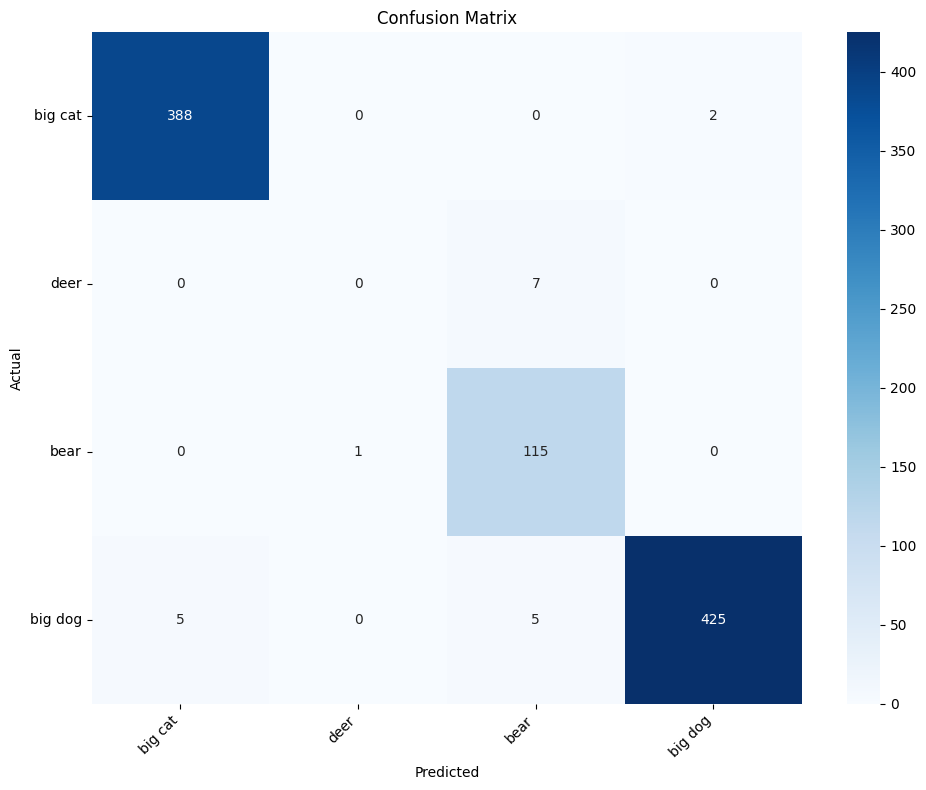

In [1]:
import os
import torch
from torchvision import transforms
from PIL import Image
from efficientnet_pytorch import EfficientNet
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

CLASS_DIRS = {
    "big cat":r"D:\SPRING 2025\Deep Learning\PROJECT\Datasets_MAIN\test_dataset\big cat",
    "deer": r"D:\SPRING 2025\Deep Learning\PROJECT\Datasets_MAIN\test_dataset\deer",
    "bear": r"D:\SPRING 2025\Deep Learning\PROJECT\Datasets_MAIN\test_dataset\bear",
    "big dog": r"D:\SPRING 2025\Deep Learning\PROJECT\Datasets_MAIN\test_dataset\big dog"
}

canonical = {
    "big cat": "big cat",
    "deer": "deer",
    "big dog": "big dog",
    "bear": "bear"
}
allowed_matches = {
    "big cat": ["leopard","tiger","cheetah"],
    "deer": ["deer"],
    "big dog": ["hyena"],
    "bear": ["brown bear", "american black bear"]
}

model = EfficientNet.from_pretrained('efficientnet-b0')
model.eval()

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

with open("imagenet_classes.txt", "r") as f:
    imagenet_classes = [line.strip() for line in f.readlines()]

def predict_image(image_path):
    try:
        img = Image.open(image_path).convert("RGB")
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None, None
    input_tensor = preprocess(img)
    input_batch = input_tensor.unsqueeze(0)
    with torch.no_grad():
        output = model(input_batch)
    probabilities = F.softmax(output, dim=1)
    score, predicted_idx = torch.max(probabilities, dim=1)
    predicted_label = imagenet_classes[predicted_idx.item()]
    return predicted_label, score.item()

def map_prediction(raw_pred):
    pred_lower = raw_pred.lower().strip()
    for canon, allowed_list in allowed_matches.items():
        for allowed_val in allowed_list:
            if allowed_val in pred_lower:
                return canon
    return pred_lower

global_y_true = []
global_y_pred = []
global_scores = []
per_class_data = {key: {"y_true": [], "y_pred": [], "scores": []} for key in CLASS_DIRS.keys()}

for class_name, dir_path in CLASS_DIRS.items():
    expected_label = canonical[class_name]
    for filename in os.listdir(dir_path):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff')):
            file_path = os.path.join(dir_path, filename)
            raw_pred, score = predict_image(file_path)
            if raw_pred is None:
                continue
            mapped_pred = map_prediction(raw_pred)
            global_y_true.append(expected_label)
            global_y_pred.append(mapped_pred)
            global_scores.append(score)
            per_class_data[class_name]["y_true"].append(expected_label)
            per_class_data[class_name]["y_pred"].append(mapped_pred)
            per_class_data[class_name]["scores"].append(score)
            print(f"File: {filename} | GT: {expected_label} | Raw: {raw_pred} | Mapped: {mapped_pred} | Score: {score:.4f}")

def compute_class_metrics(y_true_class, y_pred_class):
    accuracy = sum(1 for t, p in zip(y_true_class, y_pred_class) if t == p) / len(y_true_class) if y_true_class else 0
    TP = sum(1 for t, p in zip(global_y_true, global_y_pred) if t == p == y_true_class[0])
    FN = sum(1 for t, p in zip(global_y_true, global_y_pred) if t == y_true_class[0] and p != y_true_class[0])
    FP = sum(1 for t, p in zip(global_y_true, global_y_pred) if t != y_true_class[0] and p == y_true_class[0])
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    return accuracy, precision, recall, f1

results = {}
for class_key, data in per_class_data.items():
    y_true_class = data["y_true"]
    y_pred_class = data["y_pred"]
    acc, prec, rec, f1 = compute_class_metrics(y_true_class, y_pred_class)
    results[class_key] = {
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1,
        'y_true': y_true_class,
        'y_pred': y_pred_class,
        'scores': data["scores"]
    }
global_accuracy = accuracy_score(global_y_true, global_y_pred)
labels = list(CLASS_DIRS.keys())

# Print per-class metrics with better formatting
print("\n===== PER-CLASS METRICS =====")
for cls, metrics in results.items():
    total = len(metrics['y_true'])
    correct = sum(1 for t, p in zip(metrics['y_true'], metrics['y_pred']) if t == p)
    incorrect = total - correct
    
    print(f"\n{cls.capitalize()} Metrics:")
    print(f"Total samples: {total}")
    print(f"Correct predictions: {correct} ({correct/total*100:.2f}%)")
    print(f"Incorrect predictions: {incorrect} ({incorrect/total*100:.2f}%)")
    print(f"Accuracy: {metrics['accuracy']:.3f}")
    print(f"Precision: {metrics['precision']:.3f}")
    print(f"Recall: {metrics['recall']:.3f}")
    print(f"F1 Score: {metrics['f1']:.3f}")

# Calculate macro and weighted metrics
# Filter out predictions that aren't in our target classes
valid_indices = []
for i, (true, pred) in enumerate(zip(global_y_true, global_y_pred)):
    if true in labels and pred in labels:
        valid_indices.append(i)

filtered_y_true = [global_y_true[i] for i in valid_indices]
filtered_y_pred = [global_y_pred[i] for i in valid_indices]

# Calculate macro and weighted metrics
macro_precision = precision_score(filtered_y_true, filtered_y_pred, average='macro', zero_division=0, labels=labels)
macro_recall = recall_score(filtered_y_true, filtered_y_pred, average='macro', zero_division=0, labels=labels)
macro_f1 = f1_score(filtered_y_true, filtered_y_pred, average='macro', zero_division=0, labels=labels)

weighted_precision = precision_score(filtered_y_true, filtered_y_pred, average='weighted', zero_division=0, labels=labels)
weighted_recall = recall_score(filtered_y_true, filtered_y_pred, average='weighted', zero_division=0, labels=labels)
weighted_f1 = f1_score(filtered_y_true, filtered_y_pred, average='weighted', zero_division=0, labels=labels)

# Calculate and display overall metrics
total_samples = len(filtered_y_true)
total_correct = sum(1 for t, p in zip(filtered_y_true, filtered_y_pred) if t == p)

print("\n===== OVERALL METRICS =====")
print(f"Total samples: {total_samples}")
print(f"Correct predictions: {total_correct} ({total_correct/total_samples*100:.2f}%)")
print(f"Overall accuracy: {global_accuracy:.3f}")

print("\nMacro Average (treat all classes equally):")
print(f"Precision: {macro_precision:.3f}")
print(f"Recall: {macro_recall:.3f}")
print(f"F1 Score: {macro_f1:.3f}")

print("\nWeighted Average (weighted by class support):")
print(f"Precision: {weighted_precision:.3f}")
print(f"Recall: {weighted_recall:.3f}")
print(f"F1 Score: {weighted_f1:.3f}")

# Create and display confusion matrix
cm = confusion_matrix(filtered_y_true, filtered_y_pred, labels=labels)

plt.figure(figsize=(10, 8))
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels,
                yticklabels=labels)

plt.ylim(len(labels), 0)  # Adjust y-axis limits to match the number of classes
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()
